# Analysis of Annif suggestions in Theseus repository    

## Install and import packages
In VS Code the simplest way to install packages in correct venv is to do it in the notebook.

In [1]:
! pip install --upgrade pip setuptools wheel
! pip install ndjson pandas rdflib matplotlib jinja2

import ndjson
import pandas as pd
from rdflib import Graph, Literal, Namespace
from rdflib.namespace import OWL, SKOS
import unicodedata
import matplotlib.pyplot as plt
import matplotlib
import datetime

  Using cached pip-23.1-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1


In [2]:
# load current YSA
ysa = Graph()
ysa.parse('http://finto.fi/rest/v1/ysa/data?format=text/turtle')
print('Number of triples in YSA: ', len(ysa))

# load current Allärs
allars = Graph()
allars.parse('http://finto.fi/rest/v1/allars/data?format=text/turtle')
print('Number of triples in Allärs: ', len(allars))


Failed to convert Literal lexical form to value. Datatype=http://www.w3.org/2001/XMLSchema#date, Converter=<function parse_date at 0x7f96b20cce50>
Traceback (most recent call last):
  File "/home/local/jmminkin/git/FintoAI-data-YSO/repository-metrics-analysis/.venv/lib/python3.8/site-packages/rdflib/term.py", line 2084, in _castLexicalToPython
    return conv_func(lexical)  # type: ignore[arg-type]
  File "/home/local/jmminkin/git/FintoAI-data-YSO/repository-metrics-analysis/.venv/lib/python3.8/site-packages/isodate/isodates.py", line 201, in parse_date
    return date(sign * int(groups['year']),
ValueError: month must be in 1..12


Number of triples in YSA:  433048
Number of triples in Allärs:  412097


In [3]:
# load YSO and YSO Places
yso = Graph()
yso.parse("../Annif-corpora/vocab/yso-skos.ttl", format='turtle')
print('Number of triples in YSO+YSO Places: ', len(yso))

Number of triples in YSO+YSO Places:  830887


# Helper functions

In [4]:
YSO = Namespace('http://www.yso.fi/onto/yso/')
COMPLAIN = False  # whether to complain about unknown labels


def is_deprecated(ysouri):
    return (ysouri, OWL.deprecated, True) in yso


def label_to_yso_uris(label, voc, lang, complain=COMPLAIN):
    # based on https://github.com/NatLibFi/Annif-corpora/blob/6521d0357f3d93019f6d2838b960e80d9131735c/tools/finna-metadata-collect-scripts/create-corpus.py#L54
    
    # Remove trailing "." present in labels of some records
    try:
        value = Literal(unicodedata.normalize('NFC', label.rstrip('.')), lang)
    except Exception as e:
        print("Error normalizing label '{}'".format(label))
        return []

    for prop in (SKOS.prefLabel, SKOS.altLabel):
        vocuri = voc.value(None, prop, value, any=True)
        if vocuri is not None:
            if vocuri.startswith(YSO):
                return [vocuri]
            for matchprop in (SKOS.exactMatch, SKOS.closeMatch):
                matches = [match for match in voc.objects(vocuri, matchprop)
                           if match.startswith(YSO)]
                if matches:
                    return matches

    # hackish fallbacks for cases like "kulttuuri", where YSO Cicero is out of
    # date: look up via ysa/allars
    if lang == 'fi' and voc == yso:
        matches = label_to_yso_uris(label, ysa, lang)
        if matches:
            #print("missing fi label '{}' found via ysa".format(label))
            return matches

    if lang == 'sv' and voc == yso:
        matches = label_to_yso_uris(label, allars, lang)
        if matches:
            #print("missing sv label '{}' found via allars".format(label))
            return matches

    if complain:
        print("Unknown label '{}'".format(label))
    return []


def add_subjects_uris(df, lang, source_col):
    df["subjects_uris"] = df[source_col].apply(lambda x: [label_to_yso_uris(label, yso, lang, COMPLAIN) for label in x])
    df["subjects_uris"] = df["subjects_uris"].apply(lambda x: [str(item) for sublist in x for item in sublist])
    return df


def calc_scores(df):
    # calculate precision, recall, f1
    df["precision"] = df.apply(lambda x: len(set(x.subjects_uris) & set(x.suggestions)) / len(x.suggestions) if len(x.suggestions) > 0 else pd.np.nan, axis=1)
    df["recall"] = df.apply(lambda x: len(set(x.subjects_uris) & set(x.suggestions)) / len(x.subjects_uris) if len(x.subjects_uris) > 0 else pd.np.nan, axis=1)
    df["f1 score"] = df.apply(lambda x: 2 * x.precision * x.recall / (x.precision + x.recall) if (x.precision + x.recall) != 0 else 0, axis=1)
    df['f1 score'] = pd.to_numeric(df['f1 score'])


def plot_scores(df):
    calc_scores(df)

    # mark annif_updates in the plot
    for upd in annif_updates:
        plt.axvline(upd, color='red', linestyle='--')

    # plot precision, recall, f1 as a function of time. Label with month start
    df_monthly = df.set_index("date_accessioned").resample('MS').mean()
    df_monthly.plot(marker='o', ax=plt.gca())
    # labels = [x.strftime("%Y-%m") for x in df_monthly.index]
    # plt.gca().set_xticklabels(labels, rotation=45)
    # plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
    plt.grid()


def plot_counts(df):
    # How many records there are with suggestions each month? Label with month start
    df_monthly = df.set_index('date_accessioned').resample("MS").id.count()
    # df_monthly.plot.bar()
    plt.bar(df_monthly.index, df_monthly, width=20)
    # plt.ylabel("Number of records")
    plt.grid()


def get_number_of_rows(df):
    print("rows: ", len(df))
    print("rows with subjects_yso: ", len(df[df.subjects_yso.apply(lambda x: len(x) > 0)]))
    print("rows with subjects_all: ", len(df[df.subjects_all.apply(lambda x: len(x) > 0)]))
    print("rows with suggestions: ", len(df[df.suggestions.apply(lambda x: len(x) > 0)]))
    print("rows with subjects_uris: ", len(df[df.subjects_uris.apply(lambda x: len(x) > 0)]))
    print("rows with both suggestions & subject_uris: ", len(retain_relevant(df)))


def retain_relevant(df):
    df = df.copy()
    return df[df.suggestions.apply(lambda x: len([e for e in x if e != '']) > 0) & df.subjects_uris.apply(lambda x: len([e for e in x if e != '']) > 0)]


# Dates when Annif models were updated in Finto AI
annif_updates = [
    "2020-03-26",
    "2020-12-09",
    "2021-04-27",
    "2021-11-11",
    "2022-06-21",
    "2022-11-22",
]
# convert to datetime with utc timezone
annif_updates = [datetime.datetime.strptime(x, "%Y-%m-%d").replace(tzinfo=datetime.timezone.utc) for x in annif_updates]

def get_annif_update(date):
    return max([upd for upd in annif_updates if upd<date], default=None)


## Load data

In [5]:
with open("theseus.ndjson") as f:
    data = ndjson.load(f)
df = pd.DataFrame(data)

df.date_issued = pd.to_datetime(df.date_issued, errors='coerce', utc=True)
df.date_accessioned = pd.to_datetime(df.date_accessioned, errors='coerce', utc=True)
df['annif_update'] = df.date_accessioned.map(get_annif_update)
df.rename(columns={'lang': 'language'}, inplace=True)


print(len(df))
df_fi = df[(df.language == 'fin') | (df.language == 'fi')]
print(len(df_fi))
df_en = df[(df.language == 'eng') | (df.language == 'en')]
print(len(df_en))
df_sv = df[(df.language == 'swe') | (df.language == 'sv')]
print(len(df_sv))

146021
119877
20349
5484


In [6]:
df_fi = df_fi[df_fi.date_accessioned < "2023-04-01"]

df_fi = add_subjects_uris(df_fi, 'fi', source_col='subjects_all')
get_number_of_rows(df_fi)
# Retain only rows having both suggestions and subjects_uris
df_fi = retain_relevant(df_fi)
print()
title_str = "Theseus suomi"
df_fi.type.value_counts()

Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error no

fi=AMK-opinnäytetyö|sv=YH-examensarbete|en=Bachelor's thesis|                                                                    36027
fi=Ylempi AMK-opinnäytetyö|sv=Högre YH-examensarbete|en=Master's thesis|                                                          7166
publication                                                                                                                        854
fi=Publisher's version|sv=Publisher's version|en=Publisher's version|                                                               51
fi=Erikoistumisopintojen opinnäytetyö|sv=Examensarbete för specialiseringsutbildning|en=Thesis for specialisation studies|          36
fi=Opettaja-AMK-opinnäytetyö|sv=Examensarbete för yrkeslärarutbildning|en=Bachelor's thesis for vocational teacher education|        1
Name: type, dtype: int64

## Main results: precision, recall, and f1 over time

/tmp/ipykernel_386909/1982199275.py:71: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_monthly = df.set_index("date_accessioned").resample('MS').mean()
/tmp/ipykernel_386909/1461579767.py:10: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7f96335b7f70> starts with '_'. It is thus excluded from the legend.
  plt.legend(["_", "_", "_", "_", "_", "_", "tarkkuus", "saanti", "F1-arvo"]) #, loc='center right')
/tmp/ipykernel_386909/1461579767.py:10: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7f96351e8760> starts with '_'. It is thus excluded from the legend.
  plt.legend(["_", "_", "_", "_", "_", "_", "tarkkuus", "saanti", "F1-arvo"]) #, loc='center right')
/tmp/ipykernel_386909/1461579767.py:10: UserWarning: The label '_' of <matplotlib.lines.Line2D object

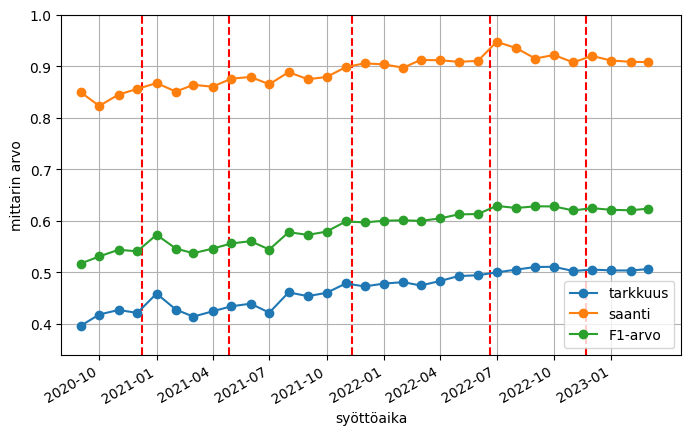

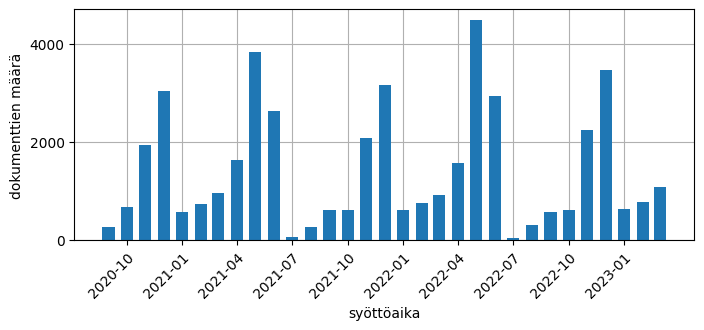

In [7]:
plt.figure(figsize=(8, 5))
plot_scores(df_fi)
plt.xlabel("syöttöaika")
plt.ylabel("mittarin arvo")
# set start of time range to 2020-09-01
plt.xlim(datetime.datetime(2020, 8, 1, tzinfo=datetime.timezone.utc))
plt.ylim(0.34, 1)

# hide legend labels of vertical lines and change other labels to finnish
plt.legend(["_", "_", "_", "_", "_", "_", "tarkkuus", "saanti", "F1-arvo"]) #, loc='center right')
# set x ticks to every 3 months starting from 2020-10, ticks to start of month
plt.gca().set_xticks(pd.date_range("2020-10-01", "2023-03-31", freq="3MS"))
# format x ticks to month-year
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m"))


plt.figure(figsize=(8, 3))
plot_counts(df_fi)
plt.xlabel("syöttöaika")
plt.ylabel("dokumenttien määrä")
plt.yticks([0, 2000, 4000, ])
# set x ticks to every 3 months starting from 2020-10, ticks to start of month
plt.gca().set_xticks(pd.date_range("2020-10-01", "2023-03-31", freq="3MS"))
# format x ticks to month-year
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m"))
# rotate x tick labels
_ = plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.gca().set_axisbelow(True)

In [8]:
# Group by annif_update and give mean precision, recall, f1
df_fi.groupby("annif_update")['precision', 'recall', 'f1 score'].agg(['mean', 'count']).style.set_caption(title_str)

/tmp/ipykernel_386909/3516352905.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_fi.groupby("annif_update")['precision', 'recall', 'f1 score'].agg(['mean', 'count']).style.set_caption(title_str)


## Distributions
Number of records with each score value

In [9]:
df_fi['precision'].value_counts(sort=False).sort_index()

0.000000     431
0.100000    1681
0.111111       7
0.125000       1
0.142857       3
0.166667       1
0.200000    4675
0.222222       6
0.250000       2
0.285714       1
0.300000    8535
0.333333      11
0.375000       2
0.400000    8371
0.428571       2
0.444444       8
0.500000    6567
0.555556       4
0.571429       1
0.600000    4752
0.625000       4
0.666667       2
0.700000    3328
0.750000       2
0.777778       2
0.800000    2249
0.833333       1
0.857143       1
0.875000       2
0.900000    1507
1.000000    1976
Name: precision, dtype: int64

In [10]:
df_fi['recall'].value_counts(sort=False).sort_index()

0.000000      431
0.100000        1
0.111111        1
0.125000        6
0.142857        9
            ...  
0.875000      374
0.888889      255
0.900000      170
0.909091      140
1.000000    30541
Name: recall, Length: 81, dtype: int64

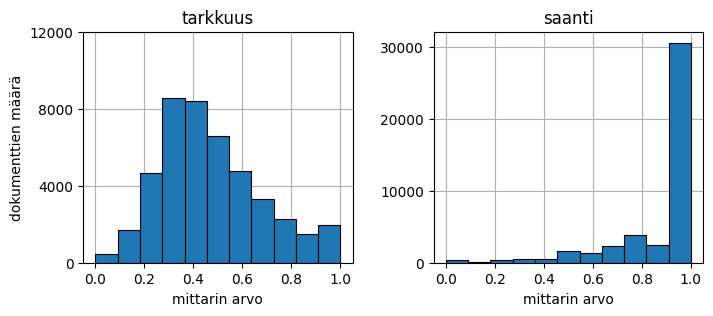

In [11]:
 # 11 bins cover all most common values of precision
df_fi[['precision', 'recall']].hist(bins=11, figsize=(8, 3), edgecolor = "black", linewidth = 0.8)
plt.gca().set_title("saanti")
# plt.ylabel("dokumenttien määrä")
plt.xlabel("mittarin arvo")
plt.yticks([0, 10000, 20000, 30000])
# put grid behind bars
plt.gca().set_axisbelow(True)

# select axis of first subplot
plt.sca(plt.gcf().axes[0])
plt.yticks([0, 4000, 8000, 12000])
plt.gca().set_title("tarkkuus")
plt.ylabel("dokumenttien määrä")
plt.xlabel("mittarin arvo")
plt.gca().set_axisbelow(True)

The histogram of recall above indicates that nearly never users assigns subjects that
are not suggested by Annif.

In [12]:
# Records without self added subjects
len(df_fi[(df_fi.recall == 1.0)]) / len(df_fi)

0.691990483743061

### How many Annif suggestions have been used without any manual corrections?

In [13]:
# select rows with precision = 1.0 and describe recall
df_fi[df_fi.precision == 1.0].recall.value_counts(sort=False).sort_index()

0.277778       1
0.294118       1
0.322581       1
0.333333       2
0.400000       1
0.416667       1
0.454545       1
0.476190       4
0.500000       3
0.526316       3
0.555556       5
0.588235       5
0.625000       6
0.666667      14
0.714286      15
0.769231      48
0.833333      82
0.909091     140
1.000000    1643
Name: recall, dtype: int64

In [14]:
# percentage of rows with precision = 1.0 and recall = 1.0
len(df_fi[(df_fi.precision == 1.0) & (df_fi.recall == 1.0)]) / len(df_fi)

0.03722669083493826

### How many documents with all suggestions rejected?

In [15]:
df_fi[df_fi.recall == 0.0].precision.value_counts(sort=False).sort_index()

0.0    431
Name: precision, dtype: int64

In [16]:
len(df_fi[df_fi.recall == 0.0]) / len(df_fi)

0.009765492239719044


## How many suggestions before and after Annif integration?

In [103]:
df_fi_before = df[((df.language == 'fin') | (df.language == 'fi')) & (df.date_accessioned < "2020-09-01") & (df.date_accessioned >= "2016-01-01")]
df_fi_before = add_subjects_uris(df_fi_before, 'fi', source_col='subjects_all')
df_fi_before = df_fi_before[df_fi_before.subjects_uris.apply(lambda x: len([e for e in x if e != '']) > 0)]
len(df_fi_before)

Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'


/tmp/ipykernel_386909/1982199275.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["subjects_uris"] = df[source_col].apply(lambda x: [label_to_yso_uris(label, yso, lang, COMPLAIN) for label in x])
/tmp/ipykernel_386909/1982199275.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["subjects_uris"] = df["subjects_uris"].apply(lambda x: [str(item) for sublist in x for item in sublist])


59339

In [104]:
df_fi_before.subjects_uris.apply(lambda x: len(x)).describe()

count    59339.000000
mean         3.325334
std          2.126571
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         64.000000
Name: subjects_uris, dtype: float64

In [105]:
df_fi.subjects_uris.apply(lambda x: len(x)).describe()

count    44135.000000
mean         5.263963
std          2.401788
min          1.000000
25%          4.000000
50%          5.000000
75%          7.000000
max         36.000000
Name: subjects_uris, dtype: float64

([<matplotlib.axis.YTick at 0x7f963b58b8e0>,
 [Text(0, 0.0, '0.00'),
  Text(0, 0.05, '0.05'),
  Text(0, 0.1, '0.10'),
  Text(0, 0.15, '0.15'),
  Text(0, 0.2, '0.20')])

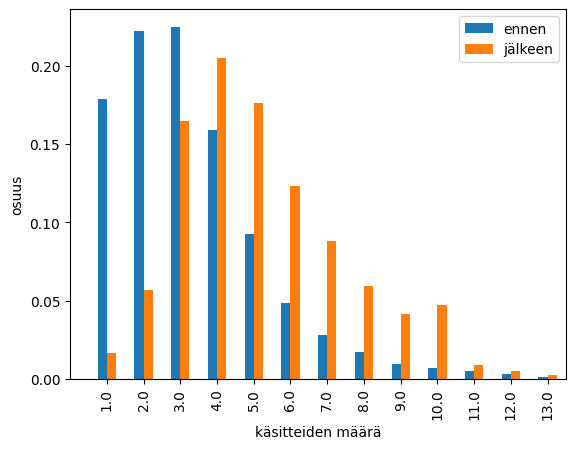

In [106]:
df_tmp = pd.DataFrame({"before": df_fi_before.subjects_uris.apply(lambda x: len(x)), "after": df_fi.subjects_uris.apply(lambda x: len(x))})
df_tmp = df_tmp.apply(pd.value_counts)
# normalize each column to sum to 1
df_tmp = df_tmp/ df_tmp.sum()
df_tmp.plot.bar()

plt.xlim(-1, 12.5)
plt.ylabel("osuus")
plt.xlabel("käsitteiden määrä")
plt.legend(["ennen", "jälkeen"])
plt.yticks([0, 0.05, 0.1, 0.15, 0.2])
# plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%d"))

In [107]:
df_fi_both = add_subjects_uris(df[(df.language == 'fin') | (df.language == 'fi')], 'fi', source_col='subjects_all')[["subjects_uris", "date_accessioned", "suggestions"]]

Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error no

/tmp/ipykernel_386909/1982199275.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["subjects_uris"] = df[source_col].apply(lambda x: [label_to_yso_uris(label, yso, lang, COMPLAIN) for label in x])
/tmp/ipykernel_386909/1982199275.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["subjects_uris"] = df["subjects_uris"].apply(lambda x: [str(item) for sublist in x for item in sublist])


In [108]:
df_fi_just_before = df_fi_before[(df_fi_before.date_accessioned >= "2020-05-01") & (df_fi_before.date_accessioned < "2020-09-01")]
len(df_fi_just_before)


6686

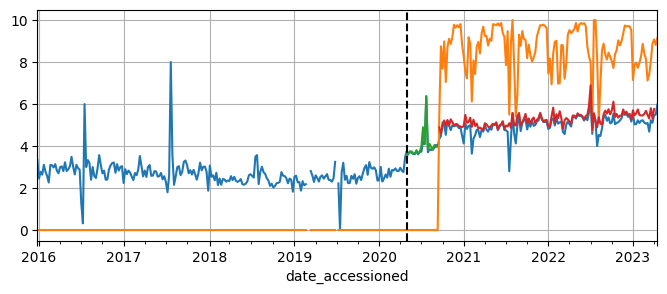

In [111]:
# plot number of subject_uris per document over time grouped by week
df_fi_both.groupby(pd.Grouper(key='date_accessioned', freq='W'))['subjects_uris'].apply(lambda x: x.apply(lambda y: len([e for e in y if e != ''])).mean()).plot(figsize=(8, 3))
df_fi_both.groupby(pd.Grouper(key='date_accessioned', freq='W'))['suggestions'].apply(lambda x: x.apply(lambda y: len([e for e in y if e != ''])).mean()).plot(figsize=(8, 3))
df_fi_just_before.groupby(pd.Grouper(key='date_accessioned', freq='W'))['subjects_uris'].apply(lambda x: x.apply(lambda y: len([e for e in y if e != ''])).mean()).plot(figsize=(8, 3))
df_fi.groupby(pd.Grouper(key='date_accessioned', freq='W'))['subjects_uris'].apply(lambda x: x.apply(lambda y: len([e for e in y if e != ''])).mean()).plot(figsize=(8, 3))

plt.grid()
# draw vertical line at 2020-05-01
plt.axvline(x="2020-05-01", color='black', linestyle='--')

For some reason the number of subjects per document started to increase before
introducing the suggestions, probably because instructions for users changed.

In [110]:
df_fi_just_before.subjects_uris.apply(lambda x: len(x)).describe()

count    6686.000000
mean        3.730033
std         1.944853
min         1.000000
25%         3.000000
50%         3.000000
75%         5.000000
max        64.000000
Name: subjects_uris, dtype: float64

## Results per degree programme

In [29]:
df_fi.degreeprogram.unique()

array(['fi=Rakennus- ja yhdyskuntatekniikka|sv=Byggnads- och samhällsteknik|en=Civil and Construction Engineering|',
       'fi=Liiketalous, hallinto ja markkinointi|sv=Företagsekonomi, förvaltning och marknadsföring|en=Business Management, Administration and Marketing|',
       'fi=Sosiaaliala|sv=Sociala området|en=Social Sciences|',
       'fi=Fysioterapia|sv=Fysioterapi|en=Physiotherapy|',
       'fi=Energia- ja ympäristötekniikka|sv=Energi- och miljöteknik|en=Energy and Enviromental Engineering|',
       'fi=Teknologiaosaamisen johtaminen|sv=Teknologibaserat ledarskap|en=Technology Management|',
       'fi=Automaatiotekniikka|sv=Automationsteknik|en=Automation Engineering|',
       'fi=Rakennusmestarit|sv=Byggmästare|en=Construction Managers|', '',
       'fi=Tietojenkäsittely|sv=Informationsbehandling|en=Business Information Technology|',
       'fi=Luonnonvara- ja ympäristöala|sv=Bioekonomi och Miljöbranschen|en=Natural Resources and Environment|',
       'fi=Sosiaali- ja terveys

In [30]:
df_fi[df_fi.degreeprogram == ''].type.unique()

array(['publication',
       "fi=Publisher's version|sv=Publisher's version|en=Publisher's version|"],
      dtype=object)

In [31]:
# assign special value to empty degreeprogram
df_fi.loc[df_fi.degreeprogram == '', 'degreeprogram'] = '(Muu julkaisu)'

In [32]:
# mean precision, recall, f1 score for each degree program and sort by f1 score
df_per_dp = df_fi.groupby("degreeprogram")['precision', 'recall', 'f1 score'].agg(['mean', 'count']).sort_values(by=('f1 score', 'mean'), ascending=False)
# rename degree program entries to take only the first part of the name
df_per_dp.index = df_per_dp.index.map(lambda x: x.split("|")[0].lstrip("fi="))

# copy to clipboard
df_per_dp[df_per_dp.precision['count'] > 400].to_clipboard()
df_per_dp[df_per_dp.precision['count'] > 400]

/tmp/ipykernel_386909/2085424453.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_per_dp = df_fi.groupby("degreeprogram")['precision', 'recall', 'f1 score'].agg(['mean', 'count']).sort_values(by=('f1 score', 'mean'), ascending=False)


precision          recall        \
                                           mean count      mean count   
degreeprogram                                                           
Esittävä taide ja musiikki             0.567549   567  0.858192   567   
(Muu julkaisu)                         0.575433   905  0.815069   905   
Kulttuurituotanto                      0.538025   405  0.861902   405   
Liikunta-ala                           0.521127   426  0.905443   426   
Poliisi                                0.505319   658  0.919894   658   
Yhteisöpedagogiikka                    0.517574   643  0.865737   643   
Fysioterapia                           0.508519   810  0.879062   810   
Terveydenhoitotyö                      0.501138  1094  0.897595  1094   
Muotoilu                               0.512215   614  0.852675   614   
Hoitotyö                               0.486237  3593  0.898936  3593   
Majoitus- ja ravitsemisala             0.478908  1062  0.905672  1062   
Media-ala                              0.500497   805  0.832954   805   
Sosiaaliala                            0.481547  3957  0.884584  3957   
Matkailu                               0.473178   686  0.898409   686   
Sosiaali- ja terveysalan johtaminen    0.471635  1316  0.893717  1316   
Energia- ja ympäristötekniikka         0.466628   889  0.900689   889   
Luonnonvara- ja ympäristöala           0.467381  1027  0.890290  1027   
Teknologiaosaamisen johtaminen         0.460977   414  0.904128   414   
Liiketalous, hallinto ja markkinointi  0.455483  9290  0.908879  9290   
Rakennusmestarit                       0.451948   616  0.924861   616   
Rakennus- ja yhdyskuntatekniikka       0.448513  1887  0.909458  1887   
Sähkötekniikka                         0.434976   893  0.921381   893   
Konetekniikka                          0.428386  1541  0.911589  1541   
Automaatiotekniikka                    0.414777   582  0.894721   582   
Tietojenkäsittely                      0.400445  1773  0.863688  1773   
Tieto- ja viestintätekniikka           0.387680  1532  0.851264  1532   

                                       f1 score        
                                           mean count  
degreeprogram                                          
Esittävä taide ja musiikki             0.660578   567  
(Muu julkaisu)                         0.648030   905  
Kulttuurituotanto                      0.638240   405  
Liikunta-ala                           0.633980   426  
Poliisi                                0.626285   658  
Yhteisöpedagogiikka                    0.623167   643  
Fysioterapia                           0.621604   810  
Terveydenhoitotyö                      0.616852  1094  
Muotoilu                               0.614132   614  
Hoitotyö                               0.607316  3593  
Majoitus- ja ravitsemisala             0.603365  1062  
Media-ala                              0.600034   805  
Sosiaaliala                            0.598656  3957  
Matkailu                               0.596961   686  
Sosiaali- ja terveysalan johtaminen    0.593229  1316  
Energia- ja ympäristötekniikka         0.589380   889  
Luonnonvara- ja ympäristöala           0.588395  1027  
Teknologiaosaamisen johtaminen         0.583037   414  
Liiketalous, hallinto ja markkinointi  0.581701  9290  
Rakennusmestarit                       0.578945   616  
Rakennus- ja yhdyskuntatekniikka       0.574634  1887  
Sähkötekniikka                         0.566544   893  
Konetekniikka                          0.557422  1541  
Automaatiotekniikka                    0.544105   582  
Tietojenkäsittely                      0.524709  1773  
Tieto- ja viestintätekniikka           0.508918  1532

/tmp/ipykernel_386909/1042979375.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  plt.xticks(pd.np.arange(0.5, 0.75, 0.05))


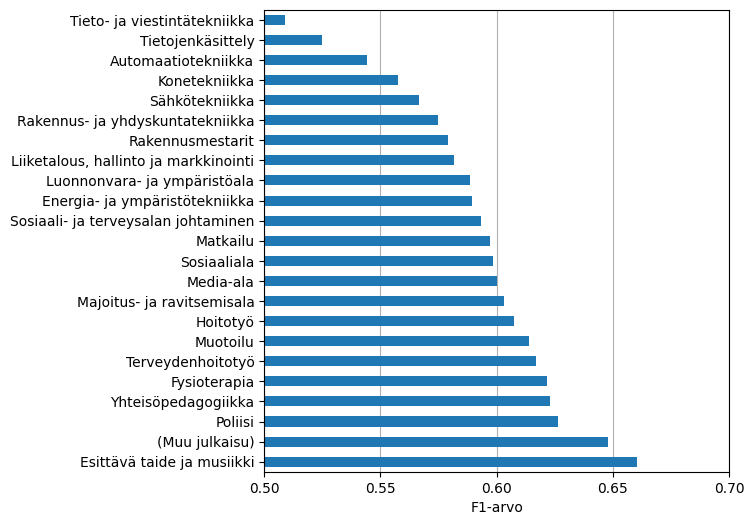

In [43]:
df_per_dp[df_per_dp.precision['count'] > 500]['f1 score']['mean'].plot.barh(figsize=(6, 6))
plt.ylabel(None)
plt.xlim(0.5, 0.7)
plt.xticks(pd.np.arange(0.5, 0.75, 0.05))
plt.xlabel("F1-arvo")
plt.grid(axis='x')
plt.gca().set_axisbelow(True)

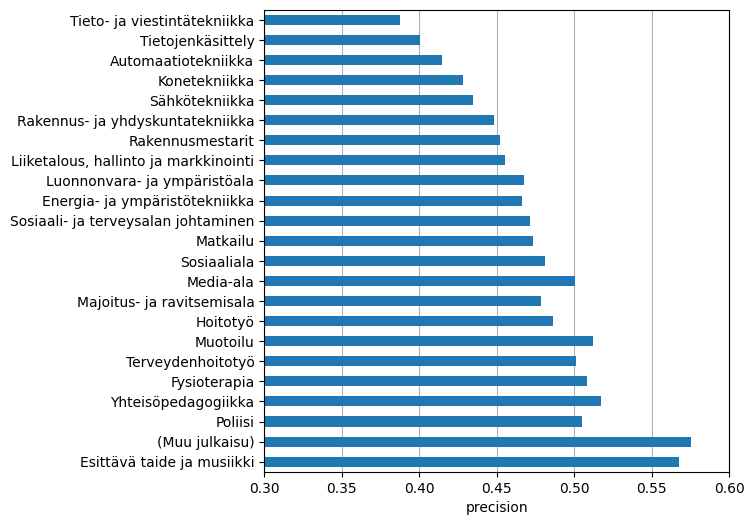

In [34]:
df_per_dp[df_per_dp.precision['count'] > 500]['precision']['mean'].plot.barh(figsize=(6, 6))
plt.ylabel(None)
plt.xlim(0.3, 0.6)
# plt.xticks(pd.np.arange(0.5, 0.75, 0.05))
plt.xlabel("precision")
plt.grid(axis='x')
plt.gca().set_axisbelow(True)

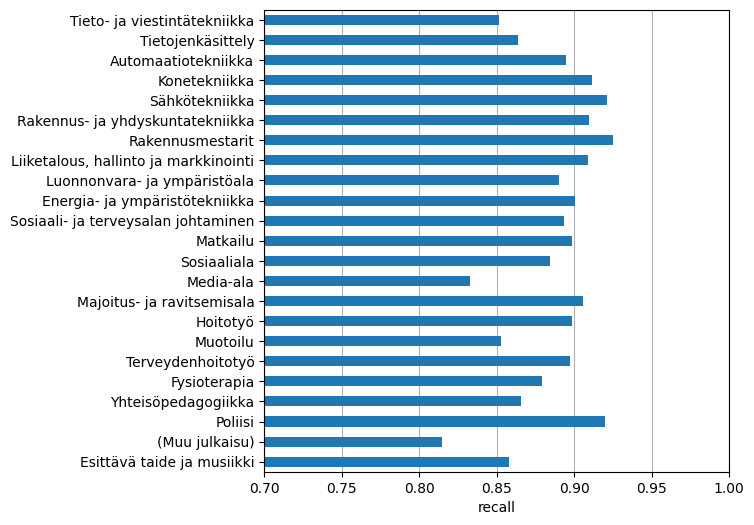

In [35]:
df_per_dp[df_per_dp.precision['count'] > 500]['recall']['mean'].plot.barh(figsize=(6, 6))
plt.ylabel(None)
plt.xlim(0.7, 1)
# plt.xticks(pd.np.arange(0.5, 0.75, 0.05))
plt.xlabel("recall")
plt.grid(axis='x')
plt.gca().set_axisbelow(True)

### (Distribution of precision and recall of some degree programs)

Text(0.5, 0.98, '(Muu julkaisu) precision mean: 0.57 recall mean: 0.81')

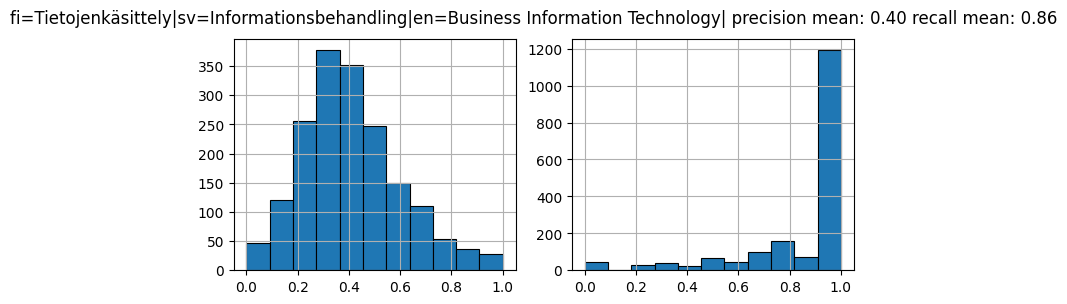

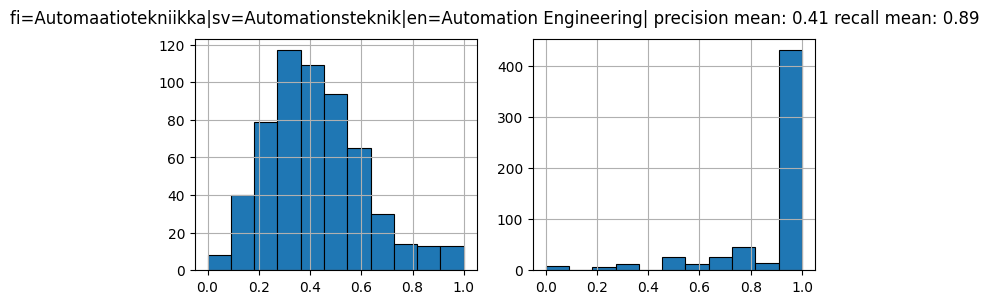

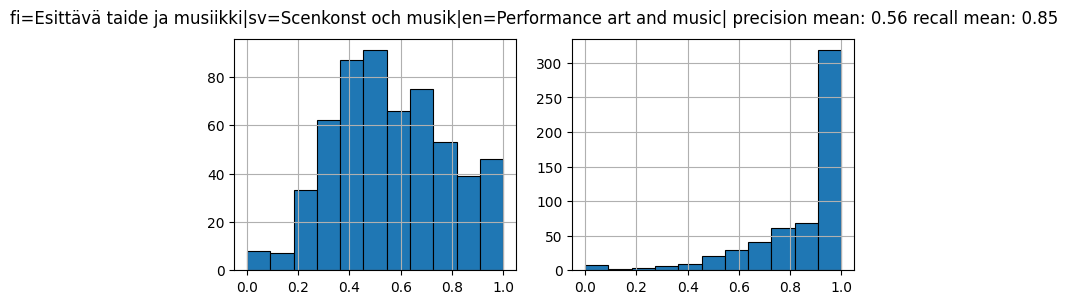

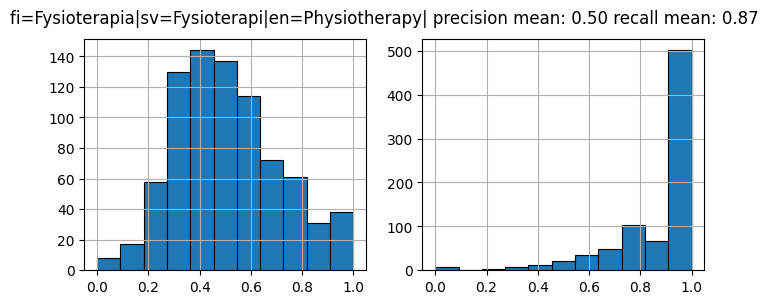

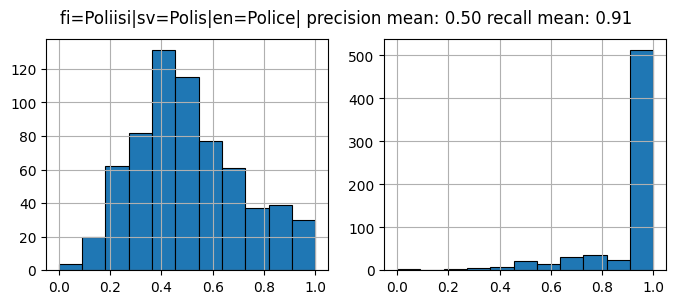

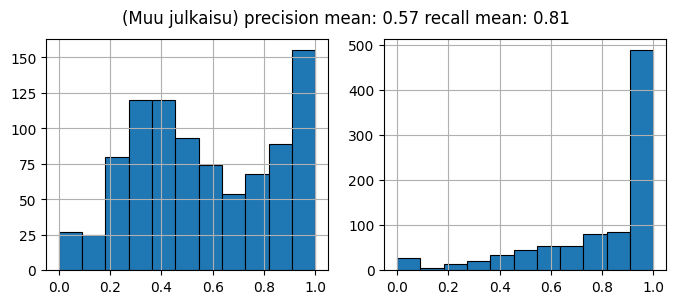

In [36]:
plt.figure()
dp = 'fi=Tietojenkäsittely|sv=Informationsbehandling|en=Business Information Technology|'
plt.subplot(1,2,1)
df_fi[df_fi.degreeprogram == dp]['precision'].hist(bins=11, figsize=(8, 3), edgecolor = "black", linewidth = 0.8)
plt.subplot(1,2,2)
df_fi[df_fi.degreeprogram == dp]['recall'].hist(bins=11, figsize=(8, 3), edgecolor = "black", linewidth = 0.8)
plt.suptitle(dp + ' precision mean: ' + str(df_fi[df_fi.degreeprogram == dp]['precision'].mean())[:4] + ' recall mean: ' + str(df_fi[df_fi.degreeprogram == dp]['recall'].mean())[:4]) 

plt.figure()
dp = 'fi=Automaatiotekniikka|sv=Automationsteknik|en=Automation Engineering|'
plt.subplot(1,2,1)
df_fi[df_fi.degreeprogram == dp]['precision'].hist(bins=11, figsize=(8, 3), edgecolor = "black", linewidth = 0.8)
plt.subplot(1,2,2)
df_fi[df_fi.degreeprogram == dp]['recall'].hist(bins=11, figsize=(8, 3), edgecolor = "black", linewidth = 0.8)
plt.suptitle(dp + ' precision mean: ' + str(df_fi[df_fi.degreeprogram == dp]['precision'].mean())[:4] + ' recall mean: ' + str(df_fi[df_fi.degreeprogram == dp]['recall'].mean())[:4]) 

plt.figure()
dp = 'fi=Esittävä taide ja musiikki|sv=Scenkonst och musik|en=Performance art and music|'
plt.subplot(1,2,1)
df_fi[df_fi.degreeprogram == dp]['precision'].hist(bins=11, figsize=(8, 3), edgecolor = "black", linewidth = 0.8)
plt.subplot(1,2,2)
df_fi[df_fi.degreeprogram == dp]['recall'].hist(bins=11, figsize=(8, 3), edgecolor = "black", linewidth = 0.8)
plt.suptitle(dp + ' precision mean: ' + str(df_fi[df_fi.degreeprogram == dp]['precision'].mean())[:4] + ' recall mean: ' + str(df_fi[df_fi.degreeprogram == dp]['recall'].mean())[:4]) 

plt.figure()
dp = 'fi=Fysioterapia|sv=Fysioterapi|en=Physiotherapy|'
plt.subplot(1,2,1)
df_fi[df_fi.degreeprogram == dp]['precision'].hist(bins=11, figsize=(8, 3), edgecolor = "black", linewidth = 0.8)
plt.subplot(1,2,2)
df_fi[df_fi.degreeprogram == dp]['recall'].hist(bins=11, figsize=(8, 3), edgecolor = "black", linewidth = 0.8)
plt.suptitle(dp + ' precision mean: ' + str(df_fi[df_fi.degreeprogram == dp]['precision'].mean())[:4] + ' recall mean: ' + str(df_fi[df_fi.degreeprogram == dp]['recall'].mean())[:4]) 
plt.figure()

dp = 'fi=Poliisi|sv=Polis|en=Police|'
plt.subplot(1,2,1)
df_fi[df_fi.degreeprogram == dp]['precision'].hist(bins=11, figsize=(8, 3), edgecolor = "black", linewidth = 0.8)
plt.subplot(1,2,2)
df_fi[df_fi.degreeprogram == dp]['recall'].hist(bins=11, figsize=(8, 3), edgecolor = "black", linewidth = 0.8)
plt.suptitle(dp + ' precision mean: ' + str(df_fi[df_fi.degreeprogram == dp]['precision'].mean())[:4] + ' recall mean: ' + str(df_fi[df_fi.degreeprogram == dp]['recall'].mean())[:4]) 

plt.figure()
dp = '(Muu julkaisu)'
plt.subplot(1,2,1)
df_fi[df_fi.degreeprogram == dp]['precision'].hist(bins=11, figsize=(8, 3), edgecolor = "black", linewidth = 0.8)
plt.subplot(1,2,2)
df_fi[df_fi.degreeprogram == dp]['recall'].hist(bins=11, figsize=(8, 3), edgecolor = "black", linewidth = 0.8)
plt.suptitle(dp + ' precision mean: ' + str(df_fi[df_fi.degreeprogram == dp]['precision'].mean())[:4] + ' recall mean: ' + str(df_fi[df_fi.degreeprogram == dp]['recall'].mean())[:4]) 


# (Correlation of F1 score in JYX test set and in Theseus)

In [37]:
df_theseus_updates = df_fi.groupby("annif_update")['precision', 'recall', 'f1 score'].agg(['mean', 'count'])
# index with month precision
df_theseus_updates.index = df_theseus_updates.index.map(lambda x: x.date())
df_theseus_updates

/tmp/ipykernel_386909/2028142037.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_theseus_updates = df_fi.groupby("annif_update")['precision', 'recall', 'f1 score'].agg(['mean', 'count'])


precision           recall         f1 score       
                  mean  count      mean  count      mean  count
annif_update                                                   
2020-03-26    0.422286   4084  0.845790   4084  0.540059   4084
2020-12-09    0.425287   5267  0.857866   5267  0.544606   5267
2021-04-27    0.439371   8892  0.877361   8892  0.560756   8892
2021-11-11    0.484445  15973  0.907410  15973  0.605770  15973
2022-06-21    0.510089   2696  0.915239   2696  0.626786   2696
2022-11-22    0.505142   7223  0.914764   7223  0.623326   7223

In [38]:
df_jyx_updates = pd.DataFrame({"f1 score": 
                               [0.4288, 0.4746, 0.4929, 0.5445, 0.5169, 0.5188]},
                              index=df_theseus_updates.index)
                              # pd.to_datetime(
                              #   ["2020-03-01", "2020-12-01", "2021-04-01", "2021-09-01", "2022-05-01", "2022-11-01"]))
df_jyx_updates

,f1 score
annif_update,
2020-03-26,0.4288
2020-12-09,0.4746
2021-04-27,0.4929
2021-11-11,0.5445
2022-06-21,0.5169
2022-11-22,0.5188


Text(0, 0.5, 'JYX')

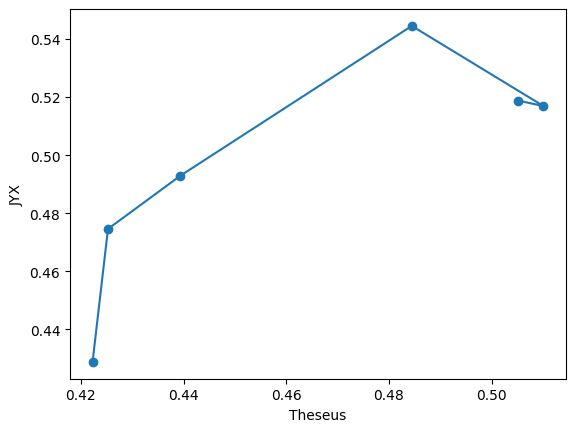

In [ ]:
plt.plot(df_theseus_updates.precision['mean'], df_jyx_updates, '-o')
plt.xlabel("Theseus")
plt.ylabel("JYX")